## Data Mining: Clustering & Association Rule Mining

In this lab, you will learn how to use clustering to find data that are similar to each other based on data attributes, without the need of having any labels to identify them. You will also use scatter plots to visualize these groups more clearly and meaningfully. You will also learn how to perform market basket analysis using associative rule mining. In particular, we will focus on the popular *apriori algorithm*, and also revise on the concepts of support, confidence and lift, looking into how these metrics can be used in the creation of rules that will mine for common patterns of items and other useful insights such as likely product pairings. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's use sample data from a popular Kaggle dataset on [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness). The 2017 data, which we will be using, contains data from 155 countries, with 12 attributes:
* Country
* Happiness Rank
* Happiness Score
* High Whisker (of the Happiness Score)
* Low Whisker (of the Happiness Score)
* Economy (GDP per capita)
* Family
* Health (Life Expectancy)
* Freedom
* Trust (Government Corruption)
* Generosity
* Dystopia Residual

To know more about these attributes, read the description of the columns [here](https://www.kaggle.com/unsdsn/world-happiness).

In [3]:
wh = pd.read_csv("whr_2017.csv") #Read the dataset
wh.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [4]:
wh.describe()

,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,78.000000,5.354019,5.452326,5.255713,0.984718,1.188898,0.551341,0.408786,0.246883,0.123120,1.850238
std,44.888751,1.131230,1.118542,1.145030,0.420793,0.287263,0.237073,0.149997,0.134780,0.101661,0.500028
min,1.000000,2.693000,2.864884,2.521116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377914
25%,39.500000,4.505500,4.608172,4.374955,0.663371,1.042635,0.369866,0.303677,0.154106,0.057271,1.591291
50%,78.000000,5.279000,5.370032,5.193152,1.064578,1.253918,0.606042,0.437454,0.231538,0.089848,1.832910
75%,116.500000,6.101500,6.194600,6.006527,1.318027,1.414316,0.723008,0.516561,0.323762,0.153296,2.144654
max,155.000000,7.537000,7.622030,7.479556,1.870766,1.610574,0.949492,0.658249,0.838075,0.464308,3.117485


You can use `shape` property on a DataFrame as well. It will get you the actual "size" of the DataFrame (rows x columns)...

In [5]:
wh.shape

(155, 12)

To check the datatypes of each attribute (column):

In [6]:
wh.dtypes

Country                           object
Happiness.Rank                     int64
Happiness.Score                  float64
Whisker.high                     float64
Whisker.low                      float64
Economy..GDP.per.Capita.         float64
Family                           float64
Health..Life.Expectancy.         float64
Freedom                          float64
Generosity                       float64
Trust..Government.Corruption.    float64
Dystopia.Residual                float64
dtype: object

Look at Country. Since string data types have variable length, it is stored in a DataFrame as `object` type. If you extract out the actual value from the Country column, we could see that it is a `str` type after all.

In [7]:
wh['Country'] # series of objects
wh['Country'][1]         # example 2
wh['Country'][len(wh)-1] # example 3

'Central African Republic'

In [8]:
s = wh['Country'][0]
print(s)
print(type(s))

Norway
<class 'str'>


### Correlational Analysis

Typically, when given some data, and assuming that it's almost clean and error-free, you should do a quick correlational analysis to examine the relationship between the numerical attributes. 

Let's take a subset of the attributes. Due to some redundancies, some attributes are definitely correlated to each other. For instance, Happiness Rank, Whisker.high and Whisker.low are all correlated to Happiness.Score. We only need one happiness measure.

In [9]:
wh1 = wh[['Happiness.Score','Economy..GDP.per.Capita.','Family','Health..Life.Expectancy.', 'Freedom', 
            'Generosity','Trust..Government.Corruption.','Dystopia.Residual']]

In [10]:
# by default, it's using pearson's correlation
cor = wh1.corr()
display(cor)    # this function only works in notebooks
                # it shows everything in dataframe view, compared to standard print

,Happiness.Score,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
Happiness.Score,1.000000,0.812469,0.752737,0.781951,0.570137,0.155256,0.429080,0.475355
Economy..GDP.per.Capita.,0.812469,1.000000,0.688296,0.843077,0.369873,-0.019011,0.350944,0.024226
Family,0.752737,0.688296,1.000000,0.612080,0.424966,0.051693,0.231841,0.070506
Health..Life.Expectancy.,0.781951,0.843077,0.612080,1.000000,0.349827,0.063191,0.279752,0.054963
Freedom,0.570137,0.369873,0.424966,0.349827,1.000000,0.316083,0.499183,0.081926
Generosity,0.155256,-0.019011,0.051693,0.063191,0.316083,1.000000,0.294159,-0.116627
Trust..Government.Corruption.,0.429080,0.350944,0.231841,0.279752,0.499183,0.294159,1.000000,-0.022755
Dystopia.Residual,0.475355,0.024226,0.070506,0.054963,0.081926,-0.116627,-0.022755,1.000000


**Seaborn** package has a nice heatmap visualization function that pretty much handles the coloring, shading and labeling. 

In [11]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

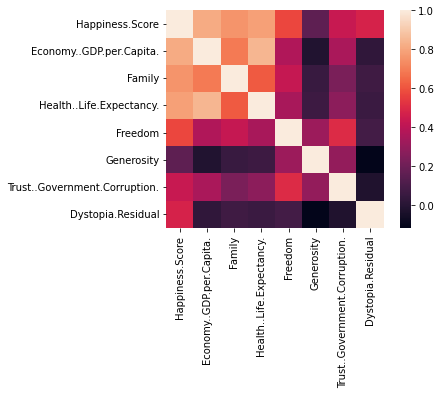

In [12]:
sns.heatmap(cor, square = True)

What can you observe from this correlation heatmap?

**Answer**: *The Generosity and Dystopia Residual have a negative correlation, which means that as Dystopia Residual is increasing, the Generosity is going to decrease. As a result, the Happiness Score may be used to determine how it relates with Economy GDP per Capita, Health Life Expectancy, Freedom and Trust Government Corruption as these values are highly correlated. The Economy GDP per Capita is the most important factor which influences other factors as Family, Health Life Expectancy and Freedom.  *

### Clustering of Countries

Since clustering is sensitive to the range of data, it is important that we **scale** the data before clustering. We now use [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from scikit-learn package to standardize the attribute data. Standardization involves removing the mean followed by scaling to unit variance (i.e. dividing by the standard deviation of the data distribution). It is sometimes also known as **z-normalization**.

In [13]:
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation 

In [14]:
ss = StandardScaler()
X = ss.fit_transform(wh1)
wh1

,Happiness.Score,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
...,...,...,...,...,...,...,...,...
150,3.471,0.368746,0.945707,0.326425,0.581844,0.252756,0.455220,0.540061
151,3.462,0.777153,0.396103,0.500533,0.081539,0.493664,0.151347,1.061574
152,3.349,0.511136,1.041990,0.364509,0.390018,0.354256,0.066035,0.621130
153,2.905,0.091623,0.629794,0.151611,0.059901,0.204435,0.084148,1.683024


In [15]:
X

array([[ 1.93599602,  1.50618765,  1.20357658, ...,  0.8569643 ,
         1.90308437,  0.85629599],
       [ 1.92269283,  1.18651768,  1.26503623, ...,  0.80685634,
         2.73999784,  0.92989102],
       [ 1.90672969,  1.1823454 ,  1.47266877, ...,  1.70201314,
         0.30006609,  0.94796425],
       ...,
       [-1.77816933, -1.12910094, -0.51306362, ...,  0.79923322,
        -0.56334657, -2.4660431 ],
       [-2.17193469, -2.12929212, -1.95262416, ..., -0.31596505,
        -0.38459935, -0.33549229],
       [-2.35994869, -2.34773594, -4.15212515, ...,  0.253028  ,
        -0.65680192,  0.43290816]])

In [16]:
X.min(axis = 0)

array([-2.35994869, -2.34773594, -4.15212515, -2.33315749, -2.73412287,
       -1.83768427, -1.21501648, -2.9540257 ])

In [17]:
X.max(axis = 0)

array([1.93599602, 2.11248814, 1.47266877, 1.68489335, 1.6685055 ,
       4.40055246, 3.36702216, 2.54256486])

In [18]:
ss = StandardScaler()
X = ss.fit_transform(wh1)
print(wh1)
print(X)     # observe the values

     Happiness.Score  Economy..GDP.per.Capita.    Family  \
0              7.537                  1.616463  1.533524   
1              7.522                  1.482383  1.551122   
2              7.504                  1.480633  1.610574   
3              7.494                  1.564980  1.516912   
4              7.469                  1.443572  1.540247   
..               ...                       ...       ...   
150            3.471                  0.368746  0.945707   
151            3.462                  0.777153  0.396103   
152            3.349                  0.511136  1.041990   
153            2.905                  0.091623  0.629794   
154            2.693                  0.000000  0.000000   

     Health..Life.Expectancy.   Freedom  Generosity  \
0                    0.796667  0.635423    0.362012   
1                    0.792566  0.626007    0.355280   
2                    0.833552  0.627163    0.475540   
3                    0.858131  0.620071    0.290549   
4   

`scikit-learn` is a rich machine learning library that provides quite a number of popular [clustering]((https://scikit-learn.org/stable/modules/clustering.html)) algorithms: [**k-means clustering**](https://scikit-learn.org/stable/modules/clustering.html#k-means), [**agglomerative clustering**](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), [**affinity propagation**](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) and many more.

Let's try with k-means. The first parameter defines the number of cluster that you wish to find. The `verbose` parameter just controls the amount of output the function prints out for checking purposes (0 for no output and a larger integer for more output). 

In [19]:
model = KMeans(2, verbose=0) # verbose = 1 to see all the iterations
model.fit(X)

KMeans(n_clusters=2)

The model of this k-means function contains the following four properties:

In [20]:
print(model.cluster_centers_.shape)

(2, 8)


In [21]:
model.cluster_centers_

array([[-0.94723707, -0.9005087 , -0.82993604, -0.88917326, -0.46144097,
         0.05357117, -0.27360516, -0.30721937],
       [ 0.68411566,  0.65036739,  0.59939825,  0.64218069,  0.33326293,
        -0.03869029,  0.19760372,  0.22188065]])

In [22]:
print(model.labels_.shape)
model.labels_

(155,)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [23]:
model.inertia_ # sum of squared distances (SSD)

840.063018269939

In [24]:
model.n_iter_

4

Here's some quick explanation of these properties:
* `cluster_centers_` contains the centers of the two clusters found thru k-means algorithm. Each of these centers have 8 values. **Note**: Does it make sense? 
* `labels_` contains the cluster labels for each data point. Since we set k=2, we get either labels 0 or 1 assigned to the data points. Since k-means clustering is an unsupervised learning method, this labels are NOT to be confused with labels that we fixed for the purpose of supervised learning. These are merely labels to indicate the data points' membership to the clusters. 
* `inertia_` is actually the sum of squared distances (SSD) of samples to their cluster centers. **Note**: Recall what is this SSD?
\begin{equation}
    SSD = \sum_{j=1}^{k}\sum_{i=1}^{n}\lVert x_i^{(j)} - c_j\rVert
\end{equation}
* `n_iter_` is the number of iterations k-means took to arrive at stable cluster centers.

Let's do a simple label check to see how k-means has done its job. \

We know that the original data has already been sorted by happiness rank. If you didn't notice this earlier, take a look now:

In [25]:
wh.head(10)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
5,Netherlands,6,7.377,7.427426,7.326574,1.503945,1.428939,0.810696,0.585384,0.470490,0.282662,2.294804
6,Canada,7,7.316,7.384403,7.247597,1.479204,1.481349,0.834558,0.611101,0.435540,0.287372,2.187264
7,New Zealand,8,7.314,7.379510,7.248490,1.405706,1.548195,0.816760,0.614062,0.500005,0.382817,2.046456
8,Sweden,9,7.284,7.344095,7.223905,1.494387,1.478162,0.830875,0.612924,0.385399,0.384399,2.097538
9,Australia,10,7.284,7.356651,7.211349,1.484415,1.510042,0.843887,0.601607,0.477699,0.301184,2.065211


The labels that were returned are also following the same sequence as the original data...

In [26]:
kmeans_labels = pd.DataFrame(model.labels_)   # put into a DataFrame. We will use this shortly...
kmeans_labels

,0
0,1
1,1
2,1
3,1
4,1
...,...
150,0
151,0
152,0
153,0


Check again the entire list of labels...

In [27]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

It appears that k-means has sort of grouped them into two clusters: One cluster (0 or 1) for countries that have a high happiness rank, and the other cluster (with the other number) for countries that have a low happiness rank. Looks like the clustering have done a decent job, except that there seems to be some ambiguity among the countries that are ranked near the middle. 

Now let us try to visualize these clusters in a more intuitive manner. It would be good to colour the data points with a similar colour according to the clusters they belong, and see where they lie in a certain 2D or 3D space. We have 8 attributes used for clustering. We cannot show all 8, so will have to do some picking. 

In [28]:
wh1.shape[1]

8

In [29]:
# First, add the labels DataFrame as a new column of the wh1 DataFrame. This will enable us to plot more easily.
wh1.insert((wh1.shape[1]), 'kmeans', kmeans_labels)

In [30]:
wh1.loc[:, 'Family':]     # take a peek at the back columns. Look at the last column

,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual,kmeans
0,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,1
1,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,1
2,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,1
3,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,1
4,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,1
...,...,...,...,...,...,...,...
150,0.945707,0.326425,0.581844,0.252756,0.455220,0.540061,0
151,0.396103,0.500533,0.081539,0.493664,0.151347,1.061574,0
152,1.041990,0.364509,0.390018,0.354256,0.066035,0.621130,0
153,0.629794,0.151611,0.059901,0.204435,0.084148,1.683024,0


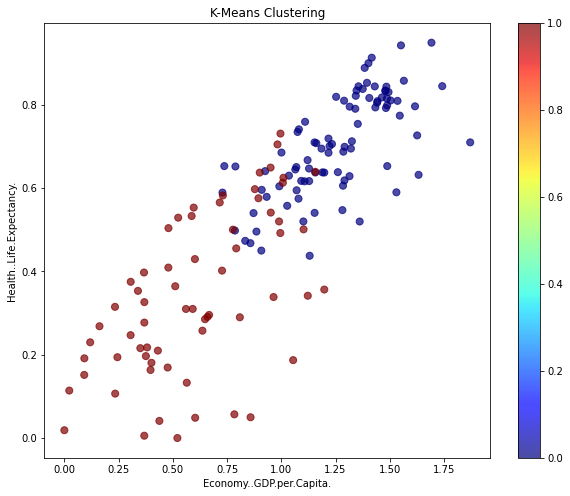

In [99]:
# Plot a scatter plot, since we want to see where the values of 2 attributes lie
v1 = wh1['Economy..GDP.per.Capita.']
v2 = wh1['Health..Life.Expectancy.']

fig = plt.figure(figsize=(10,8)) #dimension of figure
ax = fig.add_subplot(111)
scatter = ax.scatter(v1, v2, c=kmeans_labels[0],s=50,cmap='jet',alpha=0.7)
ax.set_title('K-Means Clustering')
ax.set_xlabel(v1.name)
ax.set_ylabel(v2.name)

plt.colorbar(scatter)
plt.show()

## Market Basket Analysis with Associative Rule Mining

We are going to leverage on another library (most likely you don't have it yet) called **mlxtend** created by Sebastian Raschka (who wrote a popular hands-on [Python machine learning book](https://github.com/rasbt/python-machine-learning-book)), which contains machine learning extensions to Python's standard scientific computing packages. It overlaps with many parts of **scikit-learn**, but offers some really useful functionalities for association rule mining. To install `mlxtend`, you really don't need to exit the notebook. 
> If you are on Colab, it should be already installed.<br>
If you are using Anaconda, just open another Anaconda prompt, and install it into your environment. <br>`pip install mlxtend`

The following lines of code should work if the package is installed in the environment.

In [25]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

We shall use a relatively large [online retail dataset](http://archive.ics.uci.edu/ml/datasets/online+retail) from the famous UCI ML repository. You do not need to download the data file, it is already available in your lab zip file. For Colab, upload the dataset file to the current session.

In [26]:
df = pd.read_excel('online_retail.xlsx')

There's more than 541K rows of transactional data. Phew!

In [27]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Clean it

First thing in your mind: clean it first, or at least find out if anything can be standardized or tidied up for consistency.

In [28]:
# Clean up spaces in description
df['Description'] = df['Description'].str.strip()

# Remove any rows that don't have an invoice value. Maybe these transactions are not valid?
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

# Convert invoice value to strings since we are unlikely to use these values numerical. Make them strings to be safe.
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

# Remove the credit transactions (those with invoice numbers containing C).
df = df[~df['InvoiceNo'].str.contains('C')]

Check again. We now have about 9K entries removed due to problems in their invoice numbers.

In [29]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [70]:
df.Description.str.split()

0           [WHITE, HANGING, HEART, T-LIGHT, HOLDER]
1                            [WHITE, METAL, LANTERN]
2               [CREAM, CUPID, HEARTS, COAT, HANGER]
3         [KNITTED, UNION, FLAG, HOT, WATER, BOTTLE]
4               [RED, WOOLLY, HOTTIE, WHITE, HEART.]
                             ...                    
541904             [PACK, OF, 20, SPACEBOY, NAPKINS]
541905              [CHILDREN'S, APRON, DOLLY, GIRL]
541906             [CHILDRENS, CUTLERY, DOLLY, GIRL]
541907          [CHILDRENS, CUTLERY, CIRCUS, PARADE]
541908            [BAKING, SET, 9, PIECE, RETROSPOT]
Name: Description, Length: 532621, dtype: object

In order to experiment with a small segment of customers, let's look at sales from France alone. What we are interested is a summarized table showing the data entries on the rows and the items on the columns. Group the data by 'InvoiceNo' then 'Description', the value used should be 'Quantity'. Then, set all the null (NaN) values to 0's (those with values will not be affected). Above all, set the the index (from the original row number) to 'InvoiceNo'.

This whole process consolidates the items into 1 transaction per row with each product (column side) showing its quantity sold. 

In [30]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo')
         )
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here's a selected section of the extracted data...

In [31]:
# Show a subset of columns
basket.iloc[:,[601,602,603,604,605,606,607,608]].head()

Description,INFLATABLE POLITICAL GLOBE,IVORY DINER WALL CLOCK,IVORY GIANT GARDEN THERMOMETER,IVORY HANGING DECORATION HEART,IVORY KITCHEN SCALES,IVORY PILLAR CANDLE GOLD FLOCK,IVORY PILLAR CANDLE SILVER FLOCK,IVORY WICKER HEART LARGE
InvoiceNo,,,,,,,,
536370,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


To look at the what was bought in the first invoice... 

In [32]:
f = basket.iloc[0,:]    # grab the first invoice, at row 0
f[f!=0]                 # just a quick way to show all the nonzero entries in the first invoice

Description
ALARM CLOCK BAKELIKE GREEN            12.0
ALARM CLOCK BAKELIKE PINK             24.0
ALARM CLOCK BAKELIKE RED              24.0
CHARLOTTE BAG DOLLY GIRL DESIGN       20.0
CIRCUS PARADE LUNCH BOX               24.0
INFLATABLE POLITICAL GLOBE            48.0
LUNCH BOX I LOVE LONDON               24.0
MINI JIGSAW CIRCUS PARADE             24.0
MINI JIGSAW SPACEBOY                  24.0
MINI PAINT SET VINTAGE                36.0
PANDA AND BUNNIES STICKER SHEET       12.0
POSTAGE                                3.0
RED TOADSTOOL LED NIGHT LIGHT         24.0
ROUND SNACK BOXES SET OF4 WOODLAND    24.0
SET 2 TEA TOWELS I LOVE LONDON        24.0
SET/2 RED RETROSPOT TEA TOWELS        18.0
SPACEBOY LUNCH BOX                    24.0
STARS GIFT TAPE                       24.0
VINTAGE HEADS AND TAILS CARD GAME     24.0
VINTAGE SEASIDE JIGSAW PUZZLES        12.0
Name: 536370, dtype: float64

We do not need the actual quantities. Just need to know if the product was purchased or not purchased. So, we can convert the data in each row to one-hot encoded values:

In [33]:
# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# apply the function to the dataframe
basket_sets = basket.applymap(encode_units)

In [34]:
basket_sets.iloc[:,[601,602,603,604,605,606,607,608]].head()

Description,INFLATABLE POLITICAL GLOBE,IVORY DINER WALL CLOCK,IVORY GIANT GARDEN THERMOMETER,IVORY HANGING DECORATION HEART,IVORY KITCHEN SCALES,IVORY PILLAR CANDLE GOLD FLOCK,IVORY PILLAR CANDLE SILVER FLOCK,IVORY WICKER HEART LARGE
InvoiceNo,,,,,,,,
536370,1,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0
537463,0,1,0,0,0,0,0,0


> **Side note**: `mlxtend` provides an easy function to perform this conversion if you had started off with transaction data that contains a list of items sold. For instance, if you had data looking like this (each row is a transaction of items sold):

In [35]:
minidata = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [36]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(minidata).transform(minidata)
basket_sets2 = pd.DataFrame(te_ary*1, columns=te.columns_)   # simple hack: multiply boolean with 1 converts it to number
basket_sets2

,Apple,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Unicorn,Yogurt
0,0,0,0,1,0,1,1,1,1,0,1
1,0,0,1,1,0,1,0,1,1,0,1
2,1,0,0,1,0,1,1,0,0,0,0
3,0,1,0,0,0,1,1,0,0,1,1
4,0,1,0,1,1,1,0,0,1,0,0


Back to the one-hot encoded basket set, we now drop the 'POSTAGE' column as it is of no use. It's probably a service that the retail shop provided for sending the items, not a product that we want to examine.

In [37]:
# No need to track postage
basket_sets.drop('POSTAGE', inplace=True, axis=1)

### Support

Now that the data has been properly prepared, we can now generate frequent item sets that have a **support** of at least 7% (this number was chosen to get enough useful examples):

In [38]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.071429,(4 TRADITIONAL SPINNING TOPS)
1,0.096939,(ALARM CLOCK BAKELIKE GREEN)
2,0.102041,(ALARM CLOCK BAKELIKE PINK)
3,0.094388,(ALARM CLOCK BAKELIKE RED)
4,0.081633,(BAKING SET 9 PIECE RETROSPOT)
5,0.071429,(CHILDRENS CUTLERY DOLLY GIRL)
6,0.099490,(DOLLY GIRL LUNCH BOX)
7,0.096939,(JUMBO BAG RED RETROSPOT)
8,0.076531,(JUMBO BAG WOODLAND ANIMALS)
9,0.125000,(LUNCH BAG APPLE DESIGN)


What is the meaning of **support**?

**Support** is one of the three commonly used metrics in association rule mining. It determines how popular an itemset is, as measured by the proportion of transactions in which an itemset appears.

\begin{equation}
   \text{Support} = \frac{frequency(itemset)}{N}
\end{equation}

Let's calculate this manually to prove that it is correct. First, find all nonzero entries in a particular column, i.e. 'ALARM CLOCK BAKELIKE PINK'.

In [39]:
alarmclock = basket.loc[:,'ALARM CLOCK BAKELIKE PINK'].to_numpy().nonzero()
alarmclock

(array([  0,   3,  25,  28,  41,  53,  95, 102, 120, 146, 149, 174, 175,
        187, 213, 227, 238, 239, 242, 243, 255, 265, 266, 267, 278, 283,
        294, 296, 304, 310, 321, 322, 335, 346, 367, 375, 376, 377, 388,
        391], dtype=int64),)

The support for this item (the earlier example shows support=0.102041, see third row) is the number of nonzero entries divided by the total number of entries.

In [40]:
print(alarmclock[0].size)
print(len(basket_sets))
alarmclock[0].size/len(basket_sets)   # double check with the entry in the 3rd row earlier

40
392


0.10204081632653061

### Confidence

The second measure, **Confidence**, expresses how likely item Y is purchased when item X is purchased, expressed as {$X \rightarrow Y$}. This is measured by the proportion of transactions with item X, in which item Y also appears. This metric is useful to identify pairs of products that are often sold (or bought by the customer) together. The higher the Confidence score, the more likely items X and Y are found together. A confidence score of 1 (perfect) indicates that X and Y are always bought together.

\begin{equation}
   \text{Confidence} = \frac{frequency(X,Y)}{frequency(X)}
\end{equation}

In [41]:
rules1 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273
7,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.137755,0.170918,0.104592,0.759259,4.442233,0.081047,3.443878
8,(SET/6 RED SPOTTY PAPER CUPS),(SET/20 RED RETROSPOT PAPER NAPKINS),0.137755,0.132653,0.102041,0.740741,5.584046,0.083767,3.345481
9,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER CUPS),0.132653,0.137755,0.102041,0.769231,5.584046,0.083767,3.736395


> **Side Observation**: Rules are generally in the format of $X\rightarrow Y$ (meaning X "implies" Y, or rather, when item X is purchased, Y is purchased as well). The X is the antecedent, while Y is the consequent. Notice that there can be multiple antecedents and consequents. 

In [42]:
rules1.loc[:,'antecedents']

0                           (ALARM CLOCK BAKELIKE PINK)
1                          (ALARM CLOCK BAKELIKE GREEN)
2                            (ALARM CLOCK BAKELIKE RED)
3                          (ALARM CLOCK BAKELIKE GREEN)
4                            (ALARM CLOCK BAKELIKE RED)
5                           (ALARM CLOCK BAKELIKE PINK)
6                                (DOLLY GIRL LUNCH BOX)
7                            (PLASTERS IN TIN SPACEBOY)
8                         (SET/6 RED SPOTTY PAPER CUPS)
9                  (SET/20 RED RETROSPOT PAPER NAPKINS)
10                      (SET/6 RED SPOTTY PAPER PLATES)
11                 (SET/20 RED RETROSPOT PAPER NAPKINS)
12                        (SET/6 RED SPOTTY PAPER CUPS)
13                      (SET/6 RED SPOTTY PAPER PLATES)
14    (SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...
15    (SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...
16    (SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...
17                        (SET/6 RED SPOTTY PAPE

In [43]:
rules1.iloc[14]['antecedents']

frozenset({'SET/6 RED SPOTTY PAPER CUPS', 'SET/6 RED SPOTTY PAPER PLATES'})

In [44]:
rules1.iloc[14]['consequents']

frozenset({'SET/20 RED RETROSPOT PAPER NAPKINS'})

You can limit the length of each itemset using `max_len` parameter in the [`apriori()`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) function

In [45]:
# setting max_len=2 means that each itemset (group of items) contains a maximum of 2 items, basically 1 antecedent, 1 consequent
frequent_itemsets_2 = apriori(basket_sets, min_support=0.07, use_colnames=True, max_len=2)
rules1b = association_rules(frequent_itemsets_2, metric="confidence", min_threshold=0.7)
print(rules1b)
print(rules1b.loc[:,'antecedents'])

                             antecedents  \
0            (ALARM CLOCK BAKELIKE PINK)   
1           (ALARM CLOCK BAKELIKE GREEN)   
2             (ALARM CLOCK BAKELIKE RED)   
3           (ALARM CLOCK BAKELIKE GREEN)   
4             (ALARM CLOCK BAKELIKE RED)   
5            (ALARM CLOCK BAKELIKE PINK)   
6                 (DOLLY GIRL LUNCH BOX)   
7             (PLASTERS IN TIN SPACEBOY)   
8          (SET/6 RED SPOTTY PAPER CUPS)   
9   (SET/20 RED RETROSPOT PAPER NAPKINS)   
10       (SET/6 RED SPOTTY PAPER PLATES)   
11  (SET/20 RED RETROSPOT PAPER NAPKINS)   
12         (SET/6 RED SPOTTY PAPER CUPS)   
13       (SET/6 RED SPOTTY PAPER PLATES)   

                             consequents  antecedent support  \
0           (ALARM CLOCK BAKELIKE GREEN)            0.102041   
1            (ALARM CLOCK BAKELIKE PINK)            0.096939   
2           (ALARM CLOCK BAKELIKE GREEN)            0.094388   
3             (ALARM CLOCK BAKELIKE RED)            0.096939   
4            (ALARM

### Lift

The third measure **Lift** indicates how likely item Y is purchased when item X is purchased, while controlling for how popular item Y is. The popularity control helps to alleviate the inflation of Confidence score caused by an item being more popular than other items. This is calculated by the support of X and Y (seen together) divided by the product of the supports of X and Y individually.

\begin{equation}
   \text{Lift} = \frac{Support(X,Y)}{Support(X) * Support(Y)}
\end{equation}

A lift value **greater than 1** means that item Y is likely to be bought if item X is bought, while a value **less than 1** means that item Y is unlikely to be bought if item X is bought.

In [46]:
# Create the rules
rules2 = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
6,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.125000,0.099490,0.071429,0.571429,5.743590,0.058992,2.101190
7,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273
8,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.168367,0.137755,0.089286,0.530303,3.849607,0.066092,1.835747
9,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.137755,0.168367,0.089286,0.648148,3.849607,0.066092,2.363588


So, there are altogether 25 pairings of products that are likely to be bought together by customers from France. 

**Actionable insight #1**: This mined information can be used for targeted advertisements or to determine which items can be shown together on the online e-commerce portal to maximize potential sales. Promotional discounts can also be given to the purchase of these items together.

Again, let's calculate to ensure we are able to obtain the Lift score correctly.

In [47]:
alarm_pink = basket.loc[:,'ALARM CLOCK BAKELIKE PINK'].to_numpy().nonzero()
alarm_green = basket.loc[:,'ALARM CLOCK BAKELIKE GREEN'].to_numpy().nonzero()
alarm_pink_and_green = list(set(alarm_pink[0]) & set(alarm_green[0]))
print(len(alarm_pink_and_green))

29


### Building rules

After building the frequent itemset, we can then build rules to figure out what it is telling us. 

E.g. the most common strategy is to construct a few rules with a high lift value, which means that it occurs more frequently than would be expected (since this considers the item popularity) given the number of transaction and product combinations. We can also build rules based on high confidence score as well, if you are not concerned so much with lift. This part of the analysis is where the *domain knowledge* will come in handy. As a data scientist, we have to work closely with domain experts or relevant stakeholders to construct meaningful rules.

Let's filter the data based on a large lift (6) and high confidence (0.8). We find products (or rather pairs of products) that are above these values.

In [48]:
rules2[ (rules2['lift'] >= 6) &
        (rules2['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
16,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.127551,0.132653,0.102041,0.800000,6.030769,0.085121,4.336735
18,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.137755,0.127551,0.122449,0.888889,6.968889,0.104878,7.852041
19,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.127551,0.137755,0.122449,0.960000,6.968889,0.104878,21.556122
20,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.122449,0.132653,0.099490,0.812500,6.125000,0.083247,4.625850
21,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
22,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796


It appears that the green and red alarm clocks are purchased together and the red paper cups, napkins and plates are purchased together more frequently than the overall levels of probability (see Support values) would suggest.

In [49]:
print(basket['ALARM CLOCK BAKELIKE GREEN'].sum())
print(basket['ALARM CLOCK BAKELIKE RED'].sum())

340.0
316.0
